In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE

### 1. Load the Data

The data is related to the direct marketing campaigns of Portuguese banking institution.The marketing campaigns were based on phone calls.


In [2]:
df = pd.read_csv("data/bank_data/bank-data-full.csv", sep=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


#### 1.1 Droping irrelevant columns

In this section we will be dropping the columns which are identified as redundant

- Duration - no data for duration before making a call
- pdays - previous column capture the similar information

In [3]:
df.drop("duration", axis = 1, inplace = True)
df.drop("pdays", axis = 1, inplace = True)

#### 1.2 One-hot encoding of categorial variables

In [4]:
X = df.loc[:, df.columns != 'y']
y = df['y'].map({'yes':1, 'no': 0})

In [5]:
X = pd.get_dummies(X)
X.drop(["job_unknown","marital_unknown","education_unknown","default_unknown","housing_unknown","loan_unknown","contact_telephone","month_dec","day_of_week_fri","poutcome_nonexistent"], axis = 1 , inplace = True)

#### 1.3 Training and test set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 24, test_size = 0.2, stratify = y)

In [7]:
print(X_train.shape, y_train.shape)

(32950, 51) (32950,)


In [8]:
print(X_test.shape, y_test.shape)

(8238, 51) (8238,)


### 2. Feature Engineering

#### 2.1 Feature selection

In [9]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
result = permutation_importance(RF, X_train, y_train, n_repeats = 5)
sorted_idx = result.importances_mean.argsort()

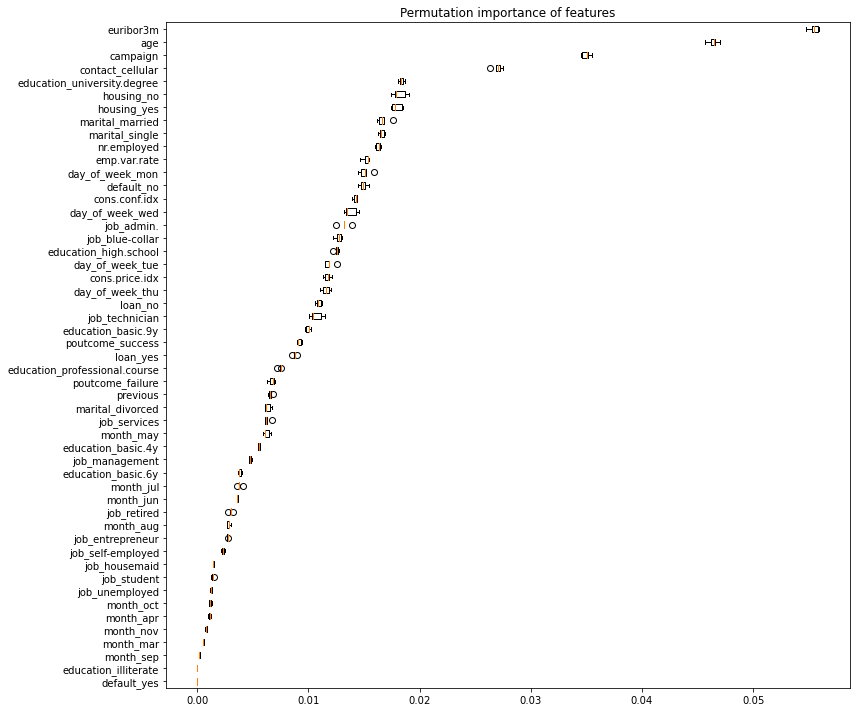

In [10]:
fig, ax = plt.subplots(figsize = (12, 10))
ax.boxplot(result.importances[sorted_idx].T,
          vert = False,
          labels=X_train.columns[sorted_idx])
ax.set_title("Permutation importance of features")
fig.tight_layout()
plt.show()

In [11]:
selected_features = list(X_train.columns[result.importances_mean > 0.01])
features = list(X_train.columns[sorted_idx][-10:])[::-1]
X_train = X_train.loc[:, selected_features]
X_test = X_test.loc[:, selected_features]

In [12]:
print(X_train.shape, X_test.shape)

(32950, 23) (8238, 23)


### 3. Models

Define a model to predict whether a call would result into subscription of term deposite based on the selected features 

#### Steps

- Normalize the Data
- Build model and tune the hyperparameters
- Measure the performance of models

#### 3.1 Normalize the Data

In [13]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### 3.2 Modeling 

#### I. Logistic Regression

In [14]:
LR_param_grid = {"C":[0.1, 0.5, 1, 2, 5], "penalty": ["l2"]}
LR = LogisticRegression(max_iter = 10000)
gs_model = GridSearchCV(LR, LR_param_grid, scoring = make_scorer(average_precision_score), cv = 5)
gs_model.fit(X_train, y_train)
LR.set_params(**gs_model.best_params_)
LR.fit(X_train, y_train)
LR_probs  = LR.predict_proba(X_test)[:, 1]
print("Best parameters for Logistic Regression : ", gs_model.best_params_)

Best parameters for Logistic Regression :  {'C': 5, 'penalty': 'l2'}


#### II. Decision Tree

In [15]:
DT_param_grid = {"max_depth": [2,5,10,20], "ccp_alpha": [0,0.1,0.5]}
DT = DecisionTreeClassifier()
gs_model = GridSearchCV(DT, DT_param_grid, scoring = make_scorer(average_precision_score), cv = 5)
gs_model.fit(X_train, y_train)
DT.set_params(**gs_model.best_params_)
DT.fit(X_train, y_train)
DT_probs = DT.predict_proba(X_test)[:,1]
print("Best parameters for Decision Tree : ", gs_model.best_params_)

Best parameters for Decision Tree :  {'ccp_alpha': 0, 'max_depth': 5}


#### III Random Forest

In [16]:
RF_param_grid = {"max_depth": [1,2,5,10,20,None], "max_features": ["sqrt", "log2"]}
gs_model = GridSearchCV(RF, RF_param_grid, scoring=make_scorer(average_precision_score), cv=5)
gs_model.fit(X_train, y_train)
RF.set_params(**gs_model.best_params_)
RF.fit(X_train, y_train)
RF_probs = RF.predict_proba(X_test)[:,1]
print("Best parameters for Random Forest : ", gs_model.best_params_)

Best parameters for Random Forest :  {'max_depth': 10, 'max_features': 'sqrt'}


#### IV. Naive Bayes

In [17]:
NB = GaussianNB()
NB.fit(X_train, y_train)
NB_probs = NB.predict_proba(X_test)[:,1]


#### IV. AdaBoost

In [18]:
AB_param_grid = {"n_estimators":[50],"learning_rate": [0.1, 0.2, 0.5,1,2,5]}
AB = AdaBoostClassifier()
gs_model = GridSearchCV(AB, AB_param_grid, scoring = make_scorer(average_precision_score), cv = 5)
gs_model.fit(X_train, y_train)
AB.set_params(**gs_model.best_params_)
AB.fit(X_train, y_train)
AB_probs = AB.predict_proba(X_test)[:,1]
print("Best parameters for AdaBoost : ", gs_model.best_params_)

Best parameters for AdaBoost :  {'learning_rate': 1, 'n_estimators': 50}


#### V. K-Nearest Neighbors

In [19]:
KNN_param_grid = {"n_neighbors": [2,3,5,10,20]}
KNN = KNeighborsClassifier()
gs_model = GridSearchCV(KNN, KNN_param_grid, scoring = make_scorer(average_precision_score), cv = 5)
gs_model.fit(X_train,y_train)
KNN.set_params(**gs_model.best_params_)
KNN.fit(X_train, y_train)
KNN_probs = KNN.predict_proba(X_test)[:,1];
print("Best parameters for K-Nearest Neighbors : ", gs_model.best_params_)

Best parameters for K-Nearest Neighbors :  {'n_neighbors': 5}


#### VI. XGBoost

In [20]:
XGB_param_grid = {"eta": [0.001,0.01, 0.05,0.1,0.5],"max_depth" : [3,5,10]}

XGB = XGBClassifier()
gs_model = GridSearchCV(XGB, XGB_param_grid, scoring = make_scorer(average_precision_score), cv = 5)
gs_model.fit(X_train, y_train)
XGB.set_params(**gs_model.best_params_)
XGB.fit(X_train, y_train)
XGB_probs = XGB.predict_proba(X_test)[:,1];

print("Best parameters for XGBoost : ", gs_model.best_params_)

Best parameters for XGBoost :  {'eta': 0.5, 'max_depth': 3}


#### VII. SVM

In [21]:
SVM = svm.SVC(C=1.0, kernel='rbf', probability=True)
SVM.fit(X_train, y_train)
SVM_probs = SVM.decision_function(X_test)

#### VIII. Neural Network

In [22]:
MLP_param_grid = dict(hidden_layer_sizes=[(30,),(50,),(70,),(100,)], 
                     activation=['relu', 'tanh', 'logistic'],
                     learning_rate=['constant', 'adaptive'])

MLP = MLPClassifier(random_state =0, max_iter=1000)
gs_model = GridSearchCV(MLP, MLP_param_grid, scoring = make_scorer(average_precision_score), cv = 5)
gs_model.fit(X_train, y_train)
MLP.set_params(**gs_model.best_params_)
MLP.fit(X_train, y_train)
MLP_probs = XGB.predict_proba(X_test)[:,1];

print("Best parameters for Neural Network : ",gs_model.best_params_)

Best parameters for Neural Network :  {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}


#### 3.3 Measure the performance of the models

The performance of the model classification is measured using below matrics
- 1) Average - Precison
- 2) F1- Score
- 3) Confusion matrix

In [23]:
summary = pd.DataFrame(columns = ["Model", "Avg-Precision", "F1-Score"])

In [24]:
#calculate best F1-score of the classifier 

def max_f1(precision, recall):
    max_f1 = 0
    for p, r in zip(precision, recall):
        if p+r == 0:
            f1_score  = 0
        else:
            f1_score = 2*p*r / (p+r)
        
        if max_f1 < f1_score:
            max_f1 = f1_score
    
    return max_f1

In [25]:
LR_precision, LR_recall, _ = precision_recall_curve(y_test, LR_probs)
LR_avg_prec = np.round(average_precision_score(y_test, LR_probs), 2)
LR_f1 = np.round(max_f1(LR_precision, LR_recall), 2) 

summary = summary.append({"Model": "Logistic Regression", "Avg-Precision": LR_avg_prec, "F1-Score": LR_f1}, ignore_index = True)

In [26]:
DT_precision, DT_recall, _ = precision_recall_curve(y_test, DT_probs)
DT_avg_prec = np.round(average_precision_score(y_test, DT_probs), 2)
DT_f1 = np.round(max_f1(DT_precision, DT_recall), 2)

summary = summary.append({"Model": "Decison Tree",
                          "Avg-Precision":DT_avg_prec ,
                          "F1-Score": DT_f1 }, ignore_index = True)

In [27]:
RF_precision, RF_recall, _ = precision_recall_curve(y_test, RF_probs)
RF_avg_prec = np.round(average_precision_score(y_test, RF_probs),2)
RF_f1 = np.round(max_f1(RF_precision, RF_recall),2)
summary = summary.append({"Model": "Random Forest",
                          "Avg-Precision":RF_avg_prec ,
                          "F1-Score": RF_f1 }, ignore_index = True)

In [28]:
NB_precision, NB_recall, _ = precision_recall_curve(y_test, NB_probs)
NB_avg_prec = np.round(average_precision_score(y_test, NB_probs),2)
NB_f1 = np.round(max_f1(NB_precision, NB_recall),2)
summary = summary.append({"Model": "Naive Bayes",
                          "Avg-Precision":NB_avg_prec ,
                          "F1-Score": NB_f1 }, ignore_index = True)

In [29]:
AB_precision, AB_recall, _ = precision_recall_curve(y_test, AB_probs)
AB_avg_prec = np.round(average_precision_score(y_test, AB_probs),2)
AB_f1 = np.round(max_f1(AB_precision, AB_recall),2)
summary = summary.append({"Model":"AdaBoost",
                          "Avg-Precision": AB_avg_prec,
                          "F1-Score":AB_f1}, ignore_index=  True)

In [30]:
KNN_precision, KNN_recall, _ = precision_recall_curve(y_test, KNN_probs)
KNN_avg_prec = np.round(average_precision_score(y_test, KNN_probs),2)
KNN_f1 = np.round(max_f1(KNN_precision, KNN_recall),2)
summary = summary.append({"Model":"K-Nearest Neighbors",
                          "Avg-Precision": KNN_avg_prec,
                          "F1-Score":KNN_f1}, ignore_index=  True)

In [31]:
XGB_precision, XGB_recall, _ = precision_recall_curve(y_test, XGB_probs)
XGB_avg_prec = np.round(average_precision_score(y_test,XGB_probs),2)
XGB_f1 = np.round(max_f1(XGB_precision, XGB_recall),2)
summary = summary.append({"Model":"XGBoost",
                          "Avg-Precision": XGB_avg_prec,
                          "F1-Score":XGB_f1}, ignore_index=  True)

In [32]:
SVM_precision, SVM_recall, _ = precision_recall_curve(y_test, SVM_probs)
SVM_avg_prec = np.round(average_precision_score(y_test,SVM_probs),2)
SVM_f1 = np.round(max_f1(SVM_precision, SVM_recall),2)
summary = summary.append({"Model":"SVM",
                          "Avg-Precision": SVM_avg_prec,
                          "F1-Score":SVM_f1}, ignore_index=  True)

In [33]:
MLP_precision, MLP_recall, _ = precision_recall_curve(y_test, MLP_probs)
MLP_avg_prec = np.round(average_precision_score(y_test,MLP_probs),2)
MLP_f1 = np.round(max_f1(MLP_precision, MLP_recall),2)
summary = summary.append({"Model":"Neural Network",
                          "Avg-Precision": MLP_avg_prec,
                          "F1-Score":MLP_f1}, ignore_index=  True)

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          paint=False,
                          cmap=plt.cm.Blues):    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    if paint:
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
    return cm

Model: LR-------------------------------------
Mean squared error: 0.1060
Variance score: -0.0602
Confusion matrix, without normalization
[[7168  142]
 [ 731  197]]


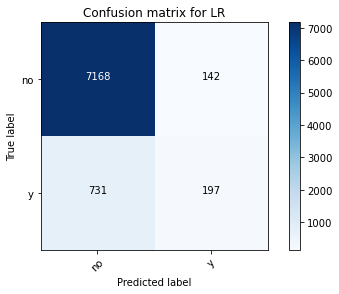

Model: DT-------------------------------------
Mean squared error: 0.1054
Variance score: -0.0541
Confusion matrix, without normalization
[[7141  169]
 [ 699  229]]


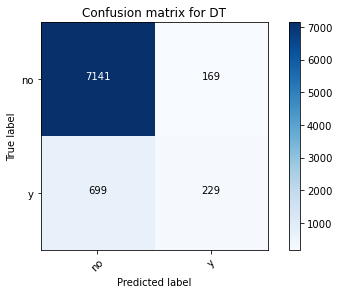

Model: RF-------------------------------------
Mean squared error: 0.1025
Variance score: -0.0249
Confusion matrix, without normalization
[[7168  142]
 [ 702  226]]


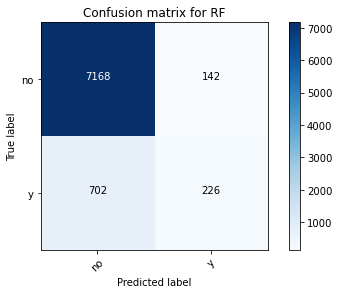

Model: AB-------------------------------------
Mean squared error: 0.1059
Variance score: -0.0589
Confusion matrix, without normalization
[[7213   97]
 [ 775  153]]


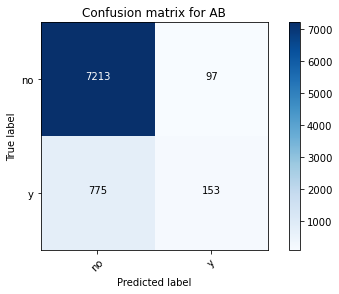

Model: KNN-------------------------------------
Mean squared error: 0.1186
Variance score: -0.1865
Confusion matrix, without normalization
[[7084  226]
 [ 751  177]]


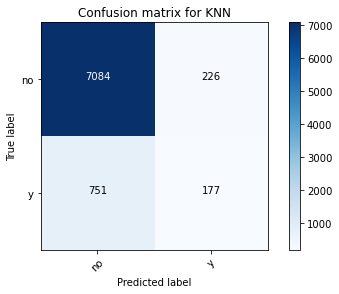

Model: XGB-------------------------------------
Mean squared error: 0.1059
Variance score: -0.0589
Confusion matrix, without normalization
[[7128  182]
 [ 690  238]]


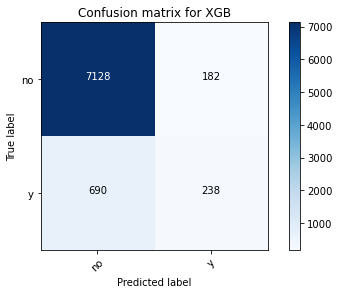

The profit expection for each model is : [12051, 15512, 15212, 7300, 9787, 16480]
done


In [35]:
models = [LR,DT,RF,AB,KNN,XGB]
modelsName = ["LR","DT","RF","AB","KNN","XGB"]

profit_matrix = [[0,-1],[-10,99]]
profit_list = list()


for m,n in zip(models, modelsName):
    predict_y = m.predict(X_test)
    # The mean squared error
    print("Model: " + str(n) + "-------------------------------------")
    print("Mean squared error: %.4f" % mean_squared_error(y_test, predict_y))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.4f' % r2_score(y_test, predict_y))
    # Confusion matrix
    cnf_matrix = confusion_matrix(y_test, predict_y)
    cm = plot_confusion_matrix(cnf_matrix, classes=['no', 'y'], normalize=False, title='Confusion matrix for '+str(n), paint=True)
    profit_list.append(np.multiply(cm, profit_matrix).sum())

print("The profit expection for each model is :",profit_list)
print("done")

In [36]:
summary

,Model,Avg-Precision,F1-Score
0,Logistic Regression,0.40,0.47
1,Decison Tree,0.38,0.48
2,Random Forest,0.44,0.50
3,Naive Bayes,0.35,0.45
4,AdaBoost,0.41,0.49
5,K-Nearest Neighbors,0.25,0.37
6,XGBoost,0.43,0.50
7,SVM,0.36,0.46
8,Neural Network,0.43,0.50


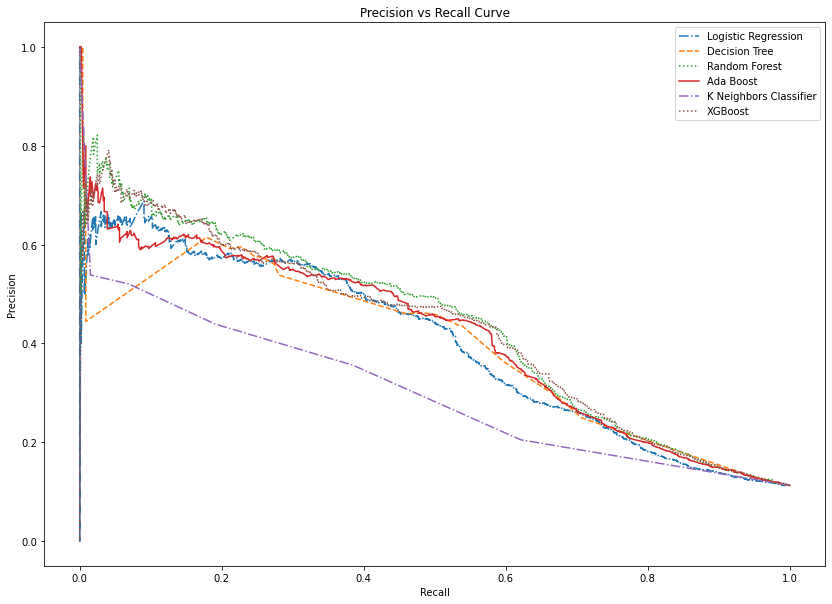

In [37]:
plt.figure(figsize = (14,10))

plt.plot(LR_recall, LR_precision, linestyle = "-.", 
         markerfacecolor = "g", label = "Logistic Regression")
plt.plot(DT_recall, DT_precision, linestyle = "--", 
         markerfacecolor = "b", label = "Decision Tree")
plt.plot(RF_recall, RF_precision, linestyle = ":", 
         markerfacecolor = "c", label = "Random Forest")
plt.plot(AB_recall, AB_precision, linestyle = "solid", 
         markerfacecolor = "m", label = "Ada Boost")
plt.plot(KNN_recall, KNN_precision, linestyle = "dashdot", 
         markerfacecolor = "y", label = "K Neighbors Classifier")
plt.plot(XGB_recall, XGB_precision, linestyle = "dotted", 
         markerfacecolor = "r", label = "XGBoost")

plt.title("Precision vs Recall Curve")
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision');

### Conclusion

In this study, various machine learning algorithms are used to explore and predict the customer for a bank based on bank marketing data. Random Forest has the best metrics and shown balanced sensitivities and interpretation of features.